In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

!ln -s /content/gdrive/ /mydrive

Mounted at /content/gdrive


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17072917245622787165
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9924012622153392067
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
!pip -q install timm

     |████████████████████████████████| 376 kB 5.5 MB/s 


In [4]:
from __future__ import print_function

import glob
from itertools import chain
import time
import os
import random
import zipfile
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import timm

%config InlineBackend.figure_format = 'retina'

In [5]:
print(f"Torch: {torch.__version__}")

Torch: 1.10.0+cu111


In [6]:
# Training settings
batch_size = 32
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [8]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225] )
    ])

In [9]:
import torchvision
from torchvision.transforms import ToTensor

train_data = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Dataset/COVID-CT-Dataset_augmented_split/train', transform=TRANSFORM_IMG)
valid_data = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Dataset/COVID-CT-Dataset_augmented_split/val', transform=TRANSFORM_IMG)
test_data = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Dataset/COVID-CT-Dataset_augmented_split/test', transform=TRANSFORM_IMG)

In [10]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader  = data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 

In [11]:
print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))
print(len(test_data), len(test_loader))

2984 94
372 12
374 12


In [12]:
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

## Effecient Attention

### Visual Transformer

In [13]:
device = 'cuda'

model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=2).to(device)

### Training

In [14]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn

In [15]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

n_epochs_stop = 3

min_val_loss = 10

In [16]:
epoch_l = []
loss_l = []
acc_l = []
v_loss_l = []
v_acc_l = []

In [17]:
since = time.time()
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
        
        epoch_l.append(epoch+1)
        loss_l.append(epoch_loss)
        acc_l.append(epoch_accuracy)
        v_loss_l.append(epoch_val_loss)
        v_acc_l.append(epoch_val_accuracy)
        
        print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n")
        
        if epoch_val_loss < min_val_loss:
            # Saving the model
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            min_val_loss = epoch_val_loss
            # early_stoped = False

        # else:
            # epochs_no_improve += 1
            # Check early stopping condition
            # if epochs_no_improve == n_epochs_stop:
                # print('Early stopping!' )
                # model.load_state_dict(best_model)
                # early_stoped = True
                # break
    # if early_stoped:
        # break

elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.4006 - acc: 0.8092 - val_loss : 0.2696 - val_acc: 0.8870



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1054 - acc: 0.9648 - val_loss : 0.1940 - val_acc: 0.9151



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0556 - acc: 0.9804 - val_loss : 0.2753 - val_acc: 0.9031



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0297 - acc: 0.9907 - val_loss : 0.4768 - val_acc: 0.8688



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0212 - acc: 0.9927 - val_loss : 0.1676 - val_acc: 0.9526



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0043 - acc: 0.9993 - val_loss : 0.1169 - val_acc: 0.9635



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0005 - acc: 1.0000 - val_loss : 0.1235 - val_acc: 0.9620



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.1236 - val_acc: 0.9609



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.1304 - val_acc: 0.9594



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.1292 - val_acc: 0.9609



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.1312 - val_acc: 0.9609



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1361 - val_acc: 0.9594



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1478 - val_acc: 0.9578



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1395 - val_acc: 0.9594



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1442 - val_acc: 0.9594



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1420 - val_acc: 0.9594



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1518 - val_acc: 0.9563



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1636 - val_acc: 0.9563



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1457 - val_acc: 0.9594



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1490 - val_acc: 0.9594

Training completed in 38m 6s


In [18]:
torch.save(model, './vit_small_patch16_224_model_pretrained.pt')

# Testing

In [19]:
since = time.time()

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

def flatten(new:list, target:list):
    for li in target:
        for value in list(li):
            new.append(value)

y_pred = []
y_true = []
flatten(y_pred, y_pred_list)
flatten(y_true, y_true_list)

elapsed_time = time.time() - since
print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

  0%|          | 0/12 [00:00<?, ?it/s]

Evaluation completed in 1m 10s


In [20]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
print("Overall accuracy:", accuracy_score(y_true, y_pred))
print("Overall F1:", f1_score(y_true, y_pred, average='weighted'))
print("Overall Loss:", log_loss(y_true, y_pred))

Overall accuracy: 0.9438502673796791
Overall F1: 0.9438595352064014
Overall Loss: 1.9393644392177178


In [21]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.9375     0.94949495]
recall: [0.94285714 0.94472362]
fscore: [0.94017094 0.94710327]
support: [175 199]


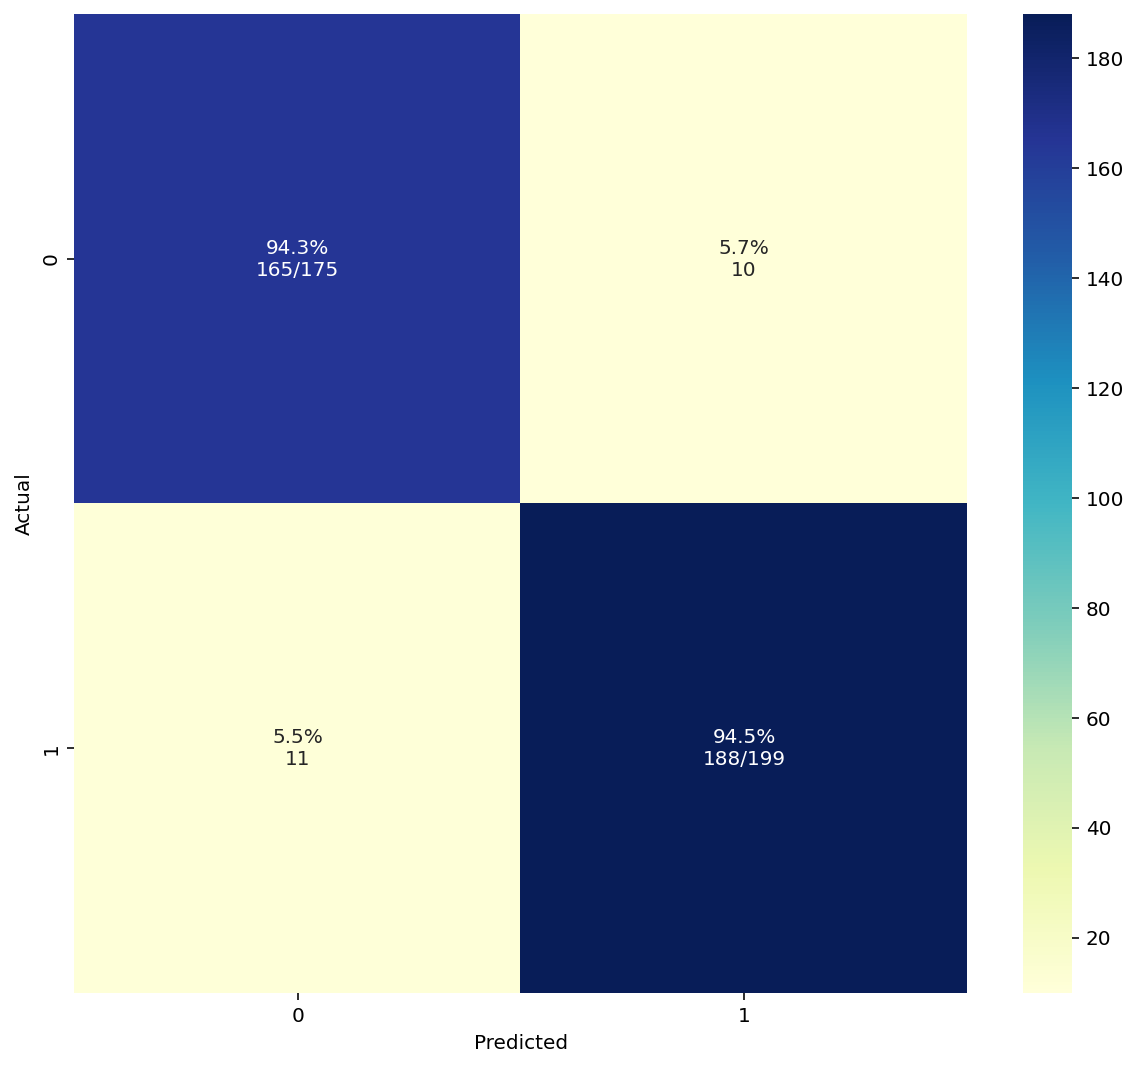

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

def plot_cm(y_true, y_pred, figsize=(10,9)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

plot_cm(y_true, y_pred)

display()

In [23]:
loss_l_c = []
acc_l_c = []
v_loss_l_c = []
v_acc_l_c = []
for x in loss_l:
    x = x.cpu().detach().numpy()
    loss_l_c.append(x)
for x in acc_l:
    x = x.cpu().detach().numpy()
    acc_l_c.append(x)
for x in v_loss_l:
    x = x.cpu().detach().numpy()
    v_loss_l_c.append(x)
for x in v_acc_l:
    x = x.cpu().detach().numpy()
    v_acc_l_c.append(x)

In [24]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=epoch_l, y=loss_l_c,
                    mode='lines+markers',
                    name='Train loss'))
fig.add_trace(go.Scatter(x=epoch_l, y=acc_l_c,
                    mode='lines+markers',
                    name='Train accuracy'))
fig.add_trace(go.Scatter(x=epoch_l, y=v_loss_l_c,
                    mode='lines+markers',
                    name='Validation loss'))
fig.add_trace(go.Scatter(x=epoch_l, y=v_acc_l_c,
                    mode='lines+markers',
                    name='Validation accuracy'))
fig.update_layout(
    title='VIT (small) Patch16_224 (pre-trained)',
    autosize=False,
    width=1000,
    height=600,
)

fig.show()

In [25]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model=torch.load('/content/gdrive/MyDrive/Experiments/ConVit/convit_model_pretrained_2.pt')  # Load from drive, not from above, skip this cell if load from above
# model.eval()

COVID-19 Negative


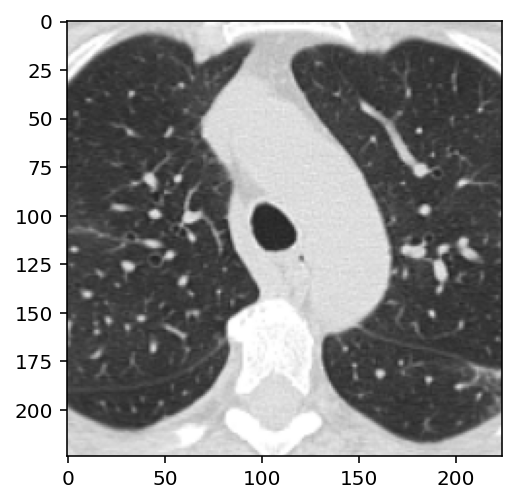

In [26]:
with torch.no_grad():
  def image_loader(image_name):
      """load image, returns cuda tensor"""
      image = Image.open(image_name)
      image = TRANSFORM_IMG(image).float()
      image = Variable(image, requires_grad=True)
      image1 = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
      return image1.cuda(), image  #assumes that you're using GPU

  image1, image2 = image_loader("/content/gdrive/MyDrive/Dataset/COVID-19_PN_Dataset/validation/COVID/Covid (1).png")

plt.imshow(image2.detach().permute(1, 2, 0))
output = model(image1)
if output[0][0] > output[0][1]:
    print("COVID-19 Positive")
else:
    print("COVID-19 Negative")

COVID-19 Positive


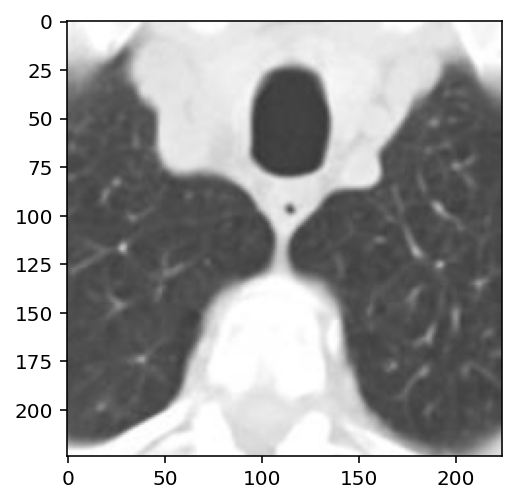

In [27]:
image1, image2 = image_loader("/content/Non-Covid (1) copy.png")  # Non-COVID images in the dataset contain Alpha channel (needs to be removed).

plt.imshow(image2.detach().permute(1, 2, 0))
output = model(image1)
if output[0][0] > output[0][1]:
    print("COVID-19 Positive")
else:
    print("COVID-19 Negative")

In [28]:
def predict_image(image):
    image_tensor = TRANSFORM_IMG(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [29]:
classes = ['COVID', 'non-COVID']
def get_random_images(num):
    # classes = test_data.classes
    indices = list(range(len(test_data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(test_data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

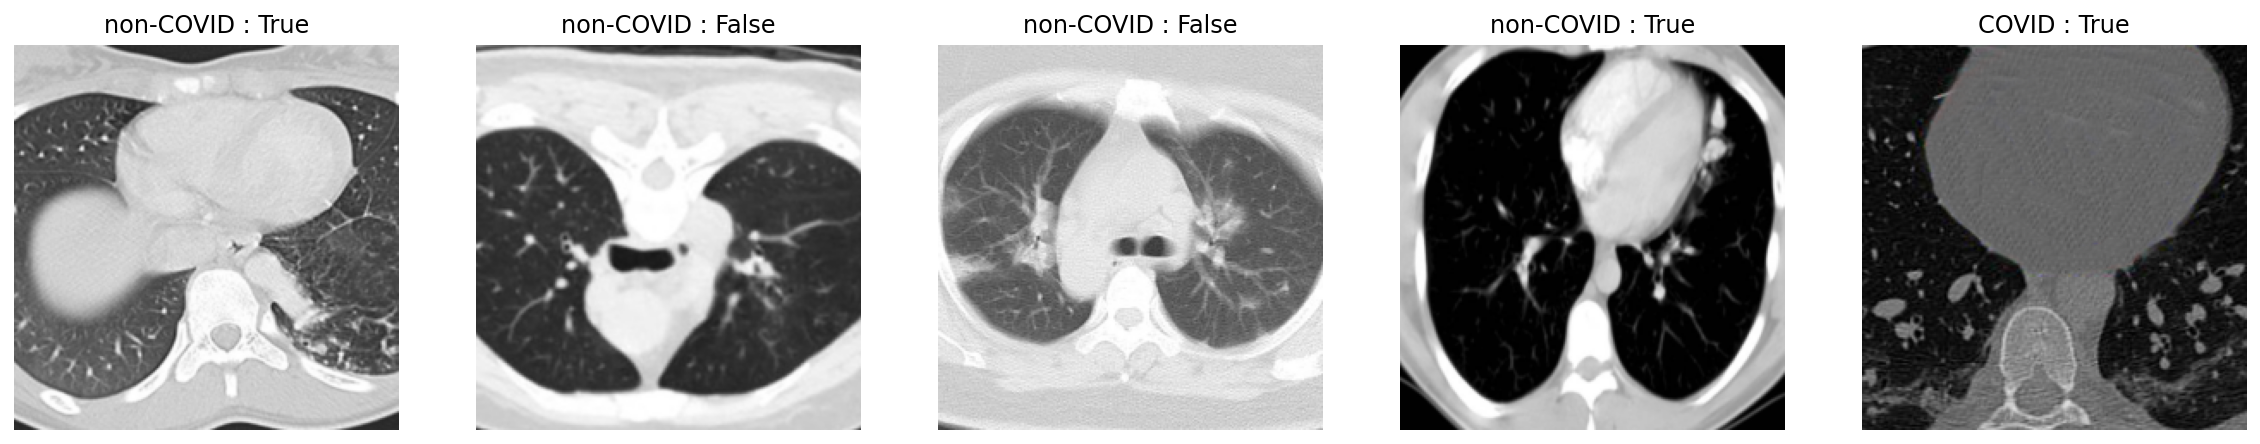

In [30]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + " : " + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

# Validate with another dataset

In [31]:
import torch.utils.data as data
data_dir_2 = '/content/gdrive/MyDrive/Dataset/COVID-19_PN_Dataset/full'
test_data_2 = torchvision.datasets.ImageFolder(data_dir_2, transform=TRANSFORM_IMG)
test_loader_2  = data.DataLoader(test_data_2, batch_size=batch_size, shuffle=True) 

In [32]:
since = time.time()

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader_2):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

def flatten(new:list, target:list):
    for li in target:
        for value in list(li):
            new.append(value)

y_pred = []
y_true = []
flatten(y_pred, y_pred_list)
flatten(y_true, y_true_list)

elapsed_time = time.time() - since
print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

  0%|          | 0/78 [00:00<?, ?it/s]

Evaluation completed in 4m 28s


In [33]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
print("Overall accuracy:", accuracy_score(y_true, y_pred))
print("Overall F1:", f1_score(y_true, y_pred, average='weighted'))
print("Overall Loss:", log_loss(y_true, y_pred))

Overall accuracy: 0.49496170898831116
Overall F1: 0.49456432412855866
Overall Loss: 17.443597010273642


In [34]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.49961861 0.48974359]
recall: [0.52316294 0.46623271]
fscore: [0.51111978 0.47769904]
support: [1252 1229]


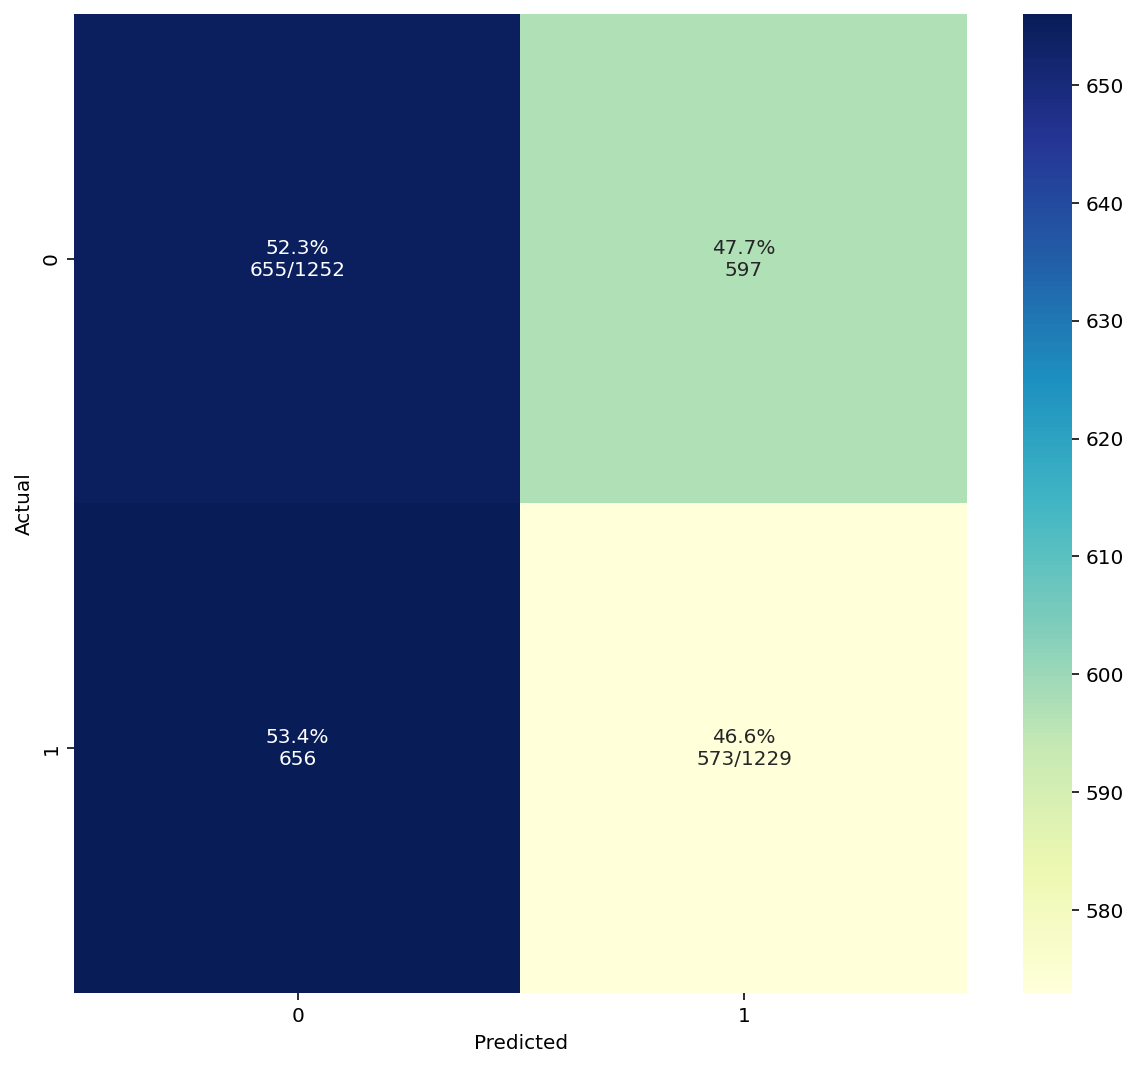

In [35]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

def plot_cm(y_true, y_pred, figsize=(10,9)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

plot_cm(y_true, y_pred)

display()